# _Causal Impact_ para Análise de Intervenção no contexto temporal

O _CausalImpact_ é um pacote em R usado para inferência causal usando modelos de séries temporais. O objetivo é estimar o efeito causal de uma intervenção em uma série temporal.

## 1. Como funciona?
   Dada uma resposta em uma série temporal e um conjunto de séries temporais de controle, o pacote constrói um modelo de série temporal. Este modelo é então usado para prever o contrafactual, ou seja, como a métrica de resposta teria acontecido após a intervenção se a intervenção não tivesse acontecido.

#### Pressupostos
   O principal pressuposto é que existe um conjunto de séries temporais que não foram afetadas pela intervenção. Se tiverem, podemos erroneamente sub ou superestimar o verdadeiro efeito. Ou podemos concluir erroneamente que houve o efeito mesmo que o mesmo não tenha ocorrido.



## 2. Configuração
Para rodar o modelo, são necessárias três bibliotecas: _stringr_, _CausalImpact_ e _lubridate_

Instalação das bibliotecas

In [87]:
install.packages("stringr")
install.packages("CausalImpact")
install.packages("lubridate")

Importação das bibliotecas para a análise

In [1]:
library('stringr')
library('CausalImpact')
library('lubridate')

Configuração do diretório de trabalho

In [49]:
setwd("/caminho/para/arquivo")

Upload e análise da base 
A base deve conter uma coluna para data e outra para o que está se medindo (conversões, sessões, microconversions) ordenada por data, por exemplo:

| Data (YYYY-MM-DD) | Sessões |
|-------------------|---------|
| 2019-01-01        |       X |
| 2019-01-02        |       Y |
| 2019-01-03        |       Z |
| ...               |     ... |

In [48]:
base <- read.csv("arquivo_entrada.csv") 
base[[1]] <- as.Date(base[[1]])
head(base)

Date,California,New.York,Texas,Washington,Illinois
<date>,<int>,<int>,<int>,<int>,<int>
2019-01-01,266,42,33,31,20
2019-01-02,726,113,86,42,46
2019-01-03,552,90,71,52,38
2019-01-04,549,103,63,25,32
2019-01-05,269,61,24,24,24
2019-01-06,302,58,32,28,22


A nossa base é composta por séries temporais em que cada coluna representa uma variável alvo de um estado. Os dados são de conversões da _Google Merchandising Store_.

#### Criando uma intervenção
Para mostrar o _CausalImpact_ em funcionamento, simularemos o efeito de uma intervenção a partir do dia 01/03/2019

In [32]:
base[60:nrow(base),2] <- base[60:nrow(base),2] + floor(runif(1, min=10, max=50))

## 3. Tratamento Base
Criação da coluna de datas no formato do _CausalImpact_, começando em janeiro/19

In [33]:
time.points <- seq.Date(as.Date("2019-01-01"), by = 1, length.out = nrow(base))

União da coluna de conversões e a coluna de data no formato feito no passo anterior

In [34]:
df = zoo(base[,2], time.points)

Definindo o pré-período 

In [36]:
pre.period <- as.Date(c("2019-01-01", "2019-02-28"))

Definindo o pós-período

In [37]:
post.period <- as.Date(c("2019-03-01", "2019-04-01"))

## 4. Modelos no _CausalImpact_
### 4. 1. Modelo simplificado
#### Execução do modelo e visualização dos resultados

In [38]:
impact = CausalImpact(df, pre.period, post.period, list(niter=5000, nseasons=7))

Plotando o gráfico

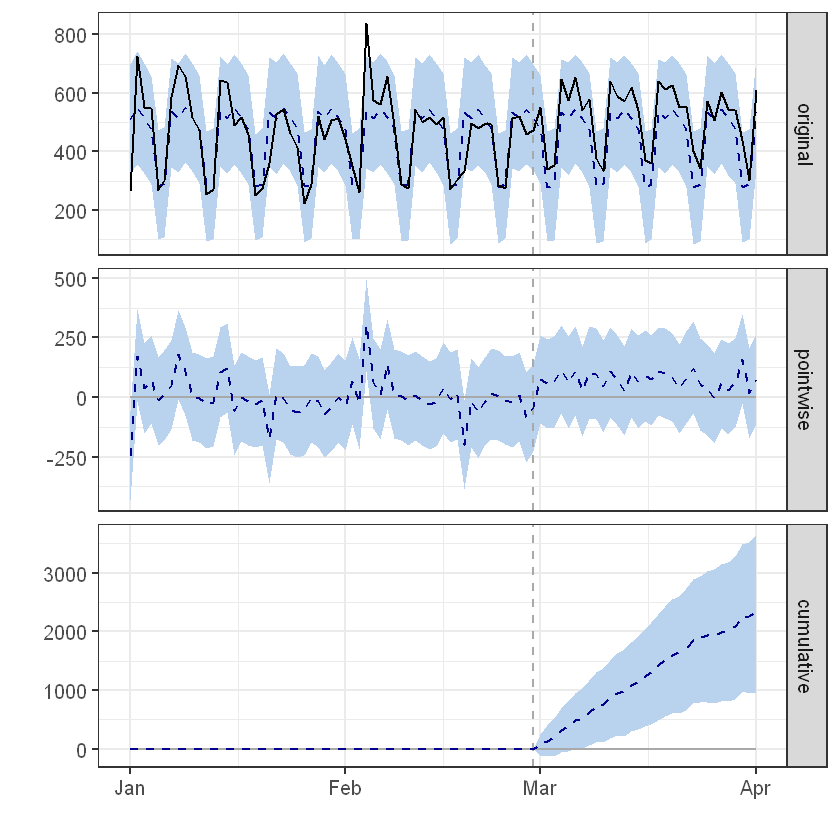

In [39]:
plot(impact)

- O **primeiro gráfico** acima representa as curvas realizada (em contínuo preto) com a prevista (pontilhada preta).
- O **segundo gráfico** mostra a diferença entre as curvas realizada e prevista.
- O **terceiro gráfico** representa a soma cumulativa diária da diferença entre o previsto e realizado. 

Resumo dos resultados do _CausalImpact_ e relatório dos resultados:

In [40]:
summary(impact)

Posterior inference {CausalImpact}

                         Average       Cumulative    
Actual                   516           16505         
Prediction (s.d.)        443 (21)      14164 (682)   
95% CI                   [402, 486]    [12862, 15550]
                                                     
Absolute effect (s.d.)   73 (21)       2341 (682)    
95% CI                   [30, 114]     [955, 3643]   
                                                     
Relative effect (s.d.)   17% (4.8%)    17% (4.8%)    
95% CI                   [6.7%, 26%]   [6.7%, 26%]   

Posterior tail-area probability p:   6e-04
Posterior prob. of a causal effect:  99.93999%

For more details, type: summary(impact, "report")



Analisando os resultados, vemos que no efeito cumulativo pós-intervenção (janela de 01/03 a 31/03/2019), houve um aumento de  17% nas conversões, com significância estatística. O desvio padrão observado foi de 21.

#### Exportação dos resultados

In [19]:
write.csv(impact$report, file='report.txt')
write.csv(impact$summary, file='summary.csv')
write.csv(impact$series, file='series.csv')

### 4. 2. Modelo Incluindo Regressores

Uma forma de melhorar o modelo é fornecendo uma ou mais covariáveis de forma que elas realizem uma regressão na nossa variável de resposta. Iremos usar as séries temporais de conversões de outros estados americanos para explicar a nossa série alvo: conversões da Califórnia.

#### Seleção da coluna de data e das colunas-alvo, sendo uma coluna para cada variável regressora
A primeira coluna representa a coluna-alvo do local onde houve intervenção. Demais colunas representam grupos de controle.

In [42]:
df = zoo(base[,2:length(base)], time.points) 

#### Definindo pré e pós-períodos

In [43]:
pre.period <- as.Date(c("2019-01-01", "2019-02-28"))
post.period <- as.Date(c("2019-03-01", "2019-04-01"))

#### Causal Impact para Conversões

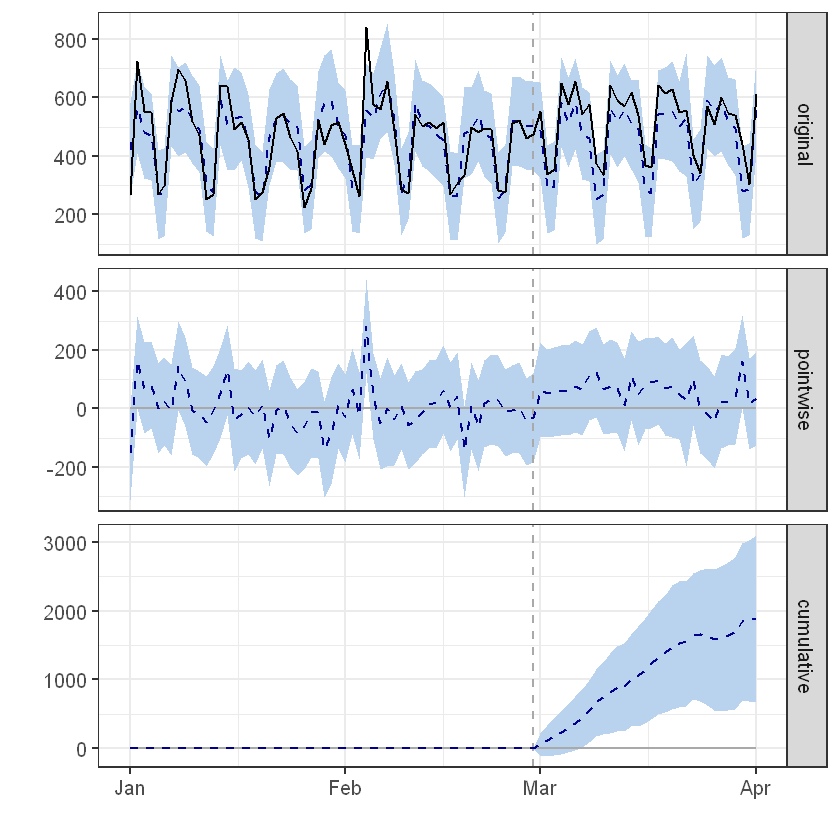

In [44]:
impact = CausalImpact(df, pre.period, post.period, list(niter=5000, nseasons=7))
plot(impact)

In [45]:
summary(impact)

Posterior inference {CausalImpact}

                         Average       Cumulative    
Actual                   516           16505         
Prediction (s.d.)        457 (19)      14611 (618)   
95% CI                   [419, 495]    [13406, 15825]
                                                     
Absolute effect (s.d.)   59 (19)       1894 (618)    
95% CI                   [21, 97]      [680, 3099]   
                                                     
Relative effect (s.d.)   13% (4.2%)    13% (4.2%)    
95% CI                   [4.7%, 21%]   [4.7%, 21%]   

Posterior tail-area probability p:   0.0014
Posterior prob. of a causal effect:  99.85978%

For more details, type: summary(impact, "report")



Utilizando as outras cidades como regressores, vemos em relação ao modelo simples que o desvio padrão caiu de 21 para 19. Houve um aumento de 13% nas conversões, com um intervalo de confiança entre 4,7% e 21%.

#### Exportação dos resultados

In [104]:
write.csv(impact$report, file='report_regressores.txt')
write.csv(impact$summary, file='summary_regressores.csv')
write.csv(impact$series, file='series_regressores.csv')

## 4. Referências
CausalImpact 1.2.3, Brodersen et al., Annals of Applied Statistics (2015). http://google.github.io/CausalImpact/